# Effect of IGF1 on nuclei size

According to [Minnis-Lyons et al.](https://www.science.org/doi/10.1126/scisignal.aay9185?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed), Notch-IGF1 signaling during liver regeneration drives biliary epithelial cell expansion and inhibits hepatocyte differentiation.

__Our hypothesis__: In Ndr organoids, big nuclei (hepatocyte-like cells) appear de-novo in biliary cell culture conditions. This means that Ndr biliary cells are differentiating to hepatocyte-like cells. If biliary cells are treated with IGF1, we expect that this differentiation will be suppressed and there should be less big nuclei.

To verify this, we will look into the following:

1. IGF1 treatment is expected to maintain cholangiocyte fate. Can this be seen in nuclei size distributions as they should be small?

2. Ndr peripheral organoids have shown more big nuclei (hepatocyte-like). Does IGF1 treatment help maintaining cholangiocyte fate (by keeping nuclear size small) more in Ndr Hilar organoids or Ndr peripheral organoids?

3. Does IGF1 treatment make Ndr hilar nuclei sizes more like Wt hilar organoids?


Finally, when we have answers to these questions, we should check if this dataset is similar to the previous one? For this we should compare untreated conditions with the previous ones. 

## Load some dependencies and set up some global variables

In [1]:
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import kstest, anderson_ksamp, wasserstein_distance, gaussian_kde
import scikit_posthocs as sp

In [3]:
condition_palette = {'WT': (61/255, 133/255, 198/255), 'Ndr': (247/255, 137/255, 23/255)}
treatment_palette = {'Control': 'green', 'IGF1': 'purple'}

## Load nuclei size datasets

We have to load an combine both datasets from IGF1 experiments.

In [4]:
def parse_condition(text):
    if 'wt' in text.lower():
        return 'WT'
    elif 'ndr' in text.lower():
        return 'Ndr'
    else:
        raise ValueError

def parse_cell_line(text):
    return text.split(' ')[0][-4:]

def parse_region(text):
    if 'peri' in text.lower():
        return 'Peripheral'
    elif 'hilar' in text.lower():
        return 'Hilar'
    else:
        raise ValueError
        
def parse_sample_number(text):
    return text.split('-')[-1]

def parse_igf1(text):
    if 'igf1' in text.lower():
        return 'IGF1'
    elif 'ctrl' in text.lower():
        return 'Control'
    else:
        raise ValueError

In [5]:
def load_dataset(filename):
    nuclei_sizes = pd.read_excel(DATA_DIR / filename, sheet_name=None)
    dfs = []
    for size_class, size_df in nuclei_sizes.items():
        size_df.drop(columns=['Unnamed: 0'], inplace=True)
        size_df['size_class'] = size_class
        dfs.append(size_df)

    nuclei_sizes = pd.concat(dfs, ignore_index=True)
    
    nuclei_sizes['condition'] = nuclei_sizes.sample_name.apply(parse_condition)
    nuclei_sizes['cell_line'] = nuclei_sizes.sample_name.apply(parse_cell_line)
    nuclei_sizes['region'] = nuclei_sizes.sample_name.apply(parse_region)
    nuclei_sizes['sample_number'] = nuclei_sizes.sample_name.apply(parse_sample_number)

    nuclei_sizes = nuclei_sizes.astype({'label': int, 'condition': 'category', 'cell_line': 'category', 'region': 'category', 'sample_number': 'category'})
    
    return nuclei_sizes

In [6]:
DATA_DIR = pathlib.Path(r'C:\Users\agucor\Karolinska Institutet\Afshan Iqbal - EdU staining IGF1 Exp')
BIG_DATA_DIR = pathlib.Path(r'C:\Users\agucor\Karolinska Institutet\Afshan Iqbal - EdU staining IGF1 Exp\sparse nuclei')

In [7]:
nuclei_size_original = pd.read_excel(DATA_DIR / 'nuclei_size.xlsx', sheet_name=None)
dfs = []
for sample_name, sample_df in nuclei_size_original.items():
    sample_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
    sample_df['sample_name'] = sample_name
    dfs.append(sample_df)

nuclei_size_original = pd.concat(dfs, ignore_index=True)

In [8]:
nuclei_size_original['condition'] = nuclei_size_original.sample_name.apply(parse_condition)
nuclei_size_original['cell_line'] = nuclei_size_original.sample_name.apply(parse_cell_line)
nuclei_size_original['region'] = nuclei_size_original.sample_name.apply(parse_region)
nuclei_size_original['igf1'] = nuclei_size_original.sample_name.apply(parse_igf1)
nuclei_size_original['sample_number'] = nuclei_size_original.sample_name.apply(parse_sample_number)

nuclei_size_original = nuclei_size_original.astype({'label': int, 'condition': 'category', 'cell_line': 'category', 'region': 'category', 'sample_number': 'category', 'igf1': 'category'})

In [9]:
nuclei_size_original

,area_2D,eccentricity,equivalent_diameter_area,intensity_mean_2D,label,z,area_3D,intensity_mean_3D,intensity_mean_edu,intensity_median,area,volume,sample_name,condition,cell_line,region,igf1,sample_number
0,134,0.694508,13.061933,50071.798507,59,4,346,31987.965318,303.234104,301.0,54.444321,1405.801117,Ndr1219 hilar ctrl -1,Ndr,1219,Hilar,Control,1
1,100,0.563438,11.283792,48793.960000,63,4,185,32735.221622,292.643243,280.0,40.630090,751.656666,Ndr1219 hilar ctrl -1,Ndr,1219,Hilar,Control,1
2,169,0.805656,14.668929,11530.520710,64,3,169,11530.520710,326.071006,312.0,68.664852,686.648522,Ndr1219 hilar ctrl -1,Ndr,1219,Hilar,Control,1
3,229,0.491526,17.075475,50432.737991,65,4,599,32087.337229,21779.205342,23463.0,93.042906,2433.742396,Ndr1219 hilar ctrl -1,Ndr,1219,Hilar,Control,1
4,171,0.588731,14.755472,54342.304094,66,4,513,35846.684211,490.385965,299.0,69.477454,2084.323621,Ndr1219 hilar ctrl -1,Ndr,1219,Hilar,Control,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184729,597,0.819093,27.570347,16572.829146,550,6,597,16572.829146,86.701843,69.0,77.491336,619.930689,Wt1225 peri IGF1 -9,WT,1225,Peripheral,IGF1,9
184730,66,0.653474,9.166996,7406.196970,551,6,66,7406.196970,76.696970,69.0,8.566881,68.535051,Wt1225 peri IGF1 -9,WT,1225,Peripheral,IGF1,9
184731,8877,0.862086,106.313440,10687.821449,552,6,8877,10687.821449,85.087642,69.0,1152.245545,9217.964359,Wt1225 peri IGF1 -9,WT,1225,Peripheral,IGF1,9
184732,558,0.877176,26.654599,9529.023297,553,6,558,9529.023297,86.193548,67.0,72.429088,579.432704,Wt1225 peri IGF1 -9,WT,1225,Peripheral,IGF1,9


In [10]:
nuclei_size_big = pd.read_excel(BIG_DATA_DIR / 'nuclei_size.xlsx', sheet_name=None)
dfs = []
for sample_name, sample_df in nuclei_size_big.items():
    sample_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
    sample_df['sample_name'] = sample_name
    dfs.append(sample_df)

nuclei_size_big = pd.concat(dfs, ignore_index=True)

In [11]:
nuclei_size_big['condition'] = nuclei_size_big.sample_name.apply(parse_condition)
nuclei_size_big['cell_line'] = nuclei_size_big.sample_name.apply(parse_cell_line)
nuclei_size_big['region'] = nuclei_size_big.sample_name.apply(parse_region)
nuclei_size_big['igf1'] = nuclei_size_big.sample_name.apply(parse_igf1)
nuclei_size_big['sample_number'] = nuclei_size_big.sample_name.apply(parse_sample_number)

nuclei_size_big = nuclei_size_big.astype({'label': int, 'condition': 'category', 'cell_line': 'category', 'region': 'category', 'sample_number': 'category', 'igf1': 'category'})

In [12]:
nuclei_size_big

,area_2D,eccentricity,equivalent_diameter_area,intensity_mean_2D,label,z,area_3D,intensity_mean_3D,intensity_mean_edu,intensity_median,area,volume,sample_name,condition,cell_line,region,igf1,sample_number
0,677,0.816172,29.359550,9778.487445,30,3,2489,5365.674166,310.468863,293.0,181.586347,6676.047547,Ndr1219 peri ctrl-10,Ndr,1219,Peripheral,Control,10
1,411,0.645107,22.875783,18280.133820,35,3,1837,7630.777899,284.964616,271.0,110.239274,4927.239592,Ndr1219 peri ctrl-10,Ndr,1219,Peripheral,Control,10
2,343,0.851170,20.897875,8409.967930,39,3,1936,4040.971591,296.362087,283.5,92.000173,5192.779450,Ndr1219 peri ctrl-10,Ndr,1219,Peripheral,Control,10
3,652,0.716493,28.812362,16049.668712,56,4,2183,10698.233623,1917.459001,1425.0,174.880796,5855.287985,Ndr1219 peri ctrl-10,Ndr,1219,Peripheral,Control,10
4,419,0.782253,23.097346,12314.892601,57,3,1157,7497.446845,2035.923941,1658.0,112.385051,3103.329454,Ndr1219 peri ctrl-10,Ndr,1219,Peripheral,Control,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4638,207,0.767882,16.234549,10168.420290,436,0,207,10168.420290,105.169082,82.0,26.868855,214.950842,Wt1225 hilar ctrl-9,WT,1225,Hilar,Control,9
4639,85,0.542482,10.403142,14924.211765,437,0,85,14924.211765,286.847059,164.0,11.033105,88.264838,Wt1225 hilar ctrl-9,WT,1225,Hilar,Control,9
4640,274,0.657265,18.677999,15847.233577,440,0,274,15847.233577,92.861314,77.5,35.565538,284.524303,Wt1225 hilar ctrl-9,WT,1225,Hilar,Control,9
4641,367,0.835926,21.616635,2475.482289,445,0,367,2475.482289,113.245232,83.0,47.637052,381.096420,Wt1225 hilar ctrl-9,WT,1225,Hilar,Control,9


In [13]:
nuclei_size = pd.concat([nuclei_size_original, nuclei_size_big], ignore_index=True)

In [14]:
nuclei_size

,area_2D,eccentricity,equivalent_diameter_area,intensity_mean_2D,label,z,area_3D,intensity_mean_3D,intensity_mean_edu,intensity_median,area,volume,sample_name,condition,cell_line,region,igf1,sample_number
0,134,0.694508,13.061933,50071.798507,59,4,346,31987.965318,303.234104,301.0,54.444321,1405.801117,Ndr1219 hilar ctrl -1,Ndr,1219,Hilar,Control,1
1,100,0.563438,11.283792,48793.960000,63,4,185,32735.221622,292.643243,280.0,40.630090,751.656666,Ndr1219 hilar ctrl -1,Ndr,1219,Hilar,Control,1
2,169,0.805656,14.668929,11530.520710,64,3,169,11530.520710,326.071006,312.0,68.664852,686.648522,Ndr1219 hilar ctrl -1,Ndr,1219,Hilar,Control,1
3,229,0.491526,17.075475,50432.737991,65,4,599,32087.337229,21779.205342,23463.0,93.042906,2433.742396,Ndr1219 hilar ctrl -1,Ndr,1219,Hilar,Control,1
4,171,0.588731,14.755472,54342.304094,66,4,513,35846.684211,490.385965,299.0,69.477454,2084.323621,Ndr1219 hilar ctrl -1,Ndr,1219,Hilar,Control,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189372,207,0.767882,16.234549,10168.420290,436,0,207,10168.420290,105.169082,82.0,26.868855,214.950842,Wt1225 hilar ctrl-9,WT,1225,Hilar,Control,9
189373,85,0.542482,10.403142,14924.211765,437,0,85,14924.211765,286.847059,164.0,11.033105,88.264838,Wt1225 hilar ctrl-9,WT,1225,Hilar,Control,9
189374,274,0.657265,18.677999,15847.233577,440,0,274,15847.233577,92.861314,77.5,35.565538,284.524303,Wt1225 hilar ctrl-9,WT,1225,Hilar,Control,9
189375,367,0.835926,21.616635,2475.482289,445,0,367,2475.482289,113.245232,83.0,47.637052,381.096420,Wt1225 hilar ctrl-9,WT,1225,Hilar,Control,9


### Description of dataset

We could see an overall descriptioin of how is the dataset composed.

How many nuclei can we find per genotype, region and treatment?

In [15]:
nuclei_size_original['cond_reg_treat'] = nuclei_size_original.apply(lambda x: '_'.join([x.condition, x.region, x.igf1]), axis=1)

Ndr 90626
WT 94108
Ndr_Hilar_Control 28071
Ndr_Hilar_IGF1 40359
Ndr_Peripheral_Control 9866
Ndr_Peripheral_IGF1 12330
WT_Hilar_Control 19319
WT_Hilar_IGF1 27415
WT_Peripheral_Control 16489
WT_Peripheral_IGF1 30885


<AxesSubplot:xlabel='cond_reg_treat'>

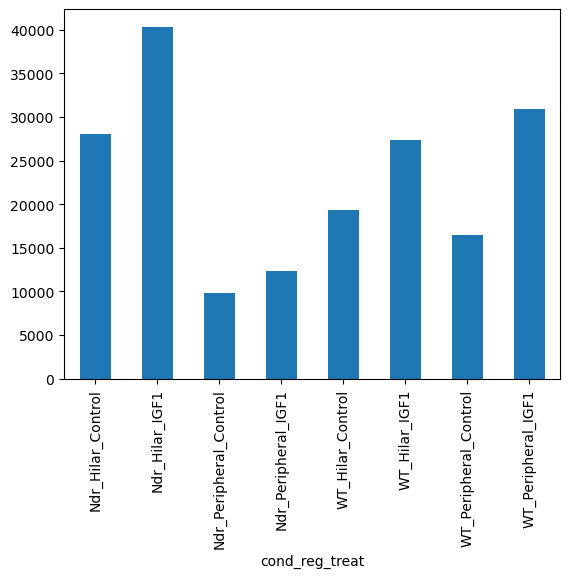

In [16]:
for cond, this_df in nuclei_size_original.groupby('condition'):
    print(cond, len(this_df))
    
for cond, this_df in nuclei_size_original.groupby('cond_reg_treat'):
    print(cond, len(this_df))

nuclei_size_original.groupby('cond_reg_treat').label.agg('count').plot(kind='bar')

How many organoids were imaged per genotype, region and treatment?

Ndr 109
WT 90
Ndr_Hilar_Control 26
Ndr_Hilar_IGF1 24
Ndr_Peripheral_Control 29
Ndr_Peripheral_IGF1 30
WT_Hilar_Control 21
WT_Hilar_IGF1 28
WT_Peripheral_Control 20
WT_Peripheral_IGF1 21


<AxesSubplot:xlabel='cond_reg_treat'>

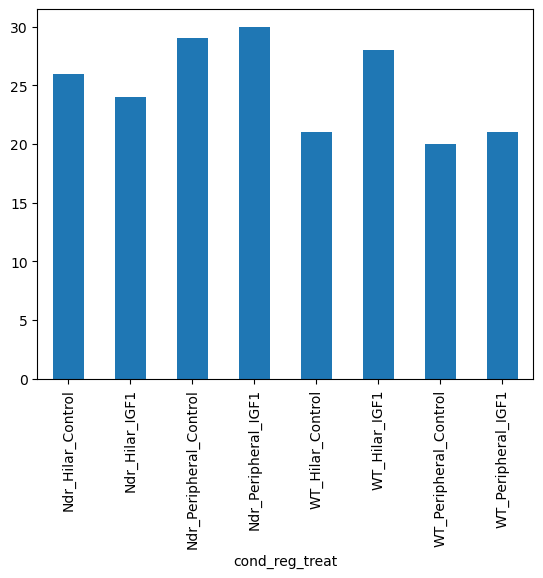

In [17]:
for cond, this_df in nuclei_size_original.groupby('condition'):
    print(cond, len(this_df.sample_name.unique()))
    
for cond, this_df in nuclei_size_original.groupby('cond_reg_treat'):
    print(cond, len(this_df.sample_name.unique()))

nuclei_size_original.groupby('cond_reg_treat').sample_name.unique().agg(len).plot(kind='bar')

## 1. Does IGF1 keep nuclei sizes small?

We can group by condition (WT and Ndr) and see whether IGF1 treated organoids show a shifted distribution of nuclei sizes towards smaller nuclei.

Are Ndr IGF1 treated nuclei smaller?
KstestResult(statistic=0.1194057452568911, pvalue=2.8252240249120366e-282)
Are WT IGF1 treated nuclei smaller?
KstestResult(statistic=0.04311540871465125, pvalue=9.266257231766919e-38)


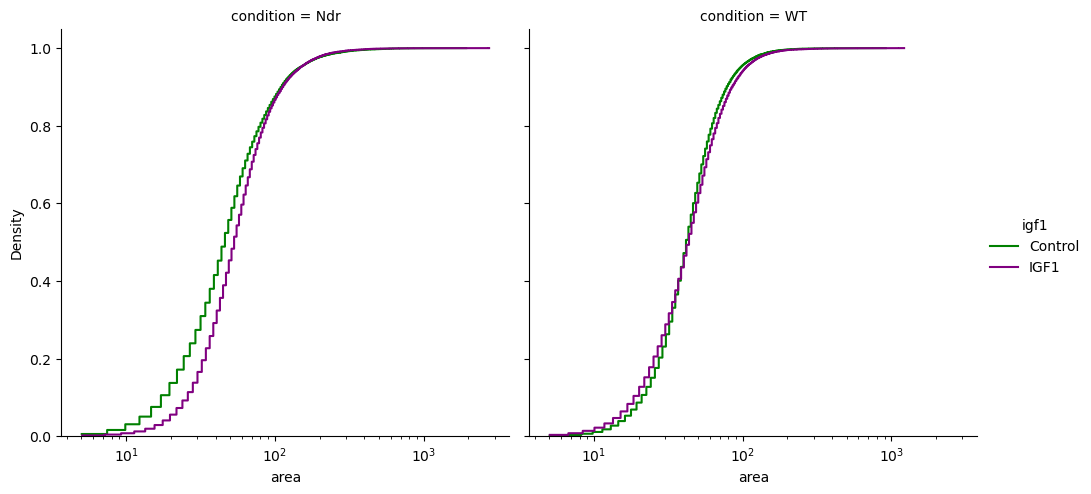

In [18]:
wt_areas = nuclei_size.query('condition == "WT"')
ndr_areas = nuclei_size.query('condition == "Ndr"')

print('Are Ndr IGF1 treated nuclei smaller?')
print(kstest(ndr_areas.query('igf1 == "IGF1"').area.values, ndr_areas.query('igf1 == "Control"').area.values, alternative='two-sided'))

print('Are WT IGF1 treated nuclei smaller?')
print(kstest(wt_areas.query('igf1 == "IGF1"').area.values, wt_areas.query('igf1 == "Control"').area.values, alternative='two-sided'))

g = sns.FacetGrid(data=nuclei_size, col='condition', hue='igf1', height=5, palette=treatment_palette)
g.map_dataframe(sns.histplot, x="area", cumulative=True, fill=False, element='step', stat='density', common_norm=False, )
g.add_legend()
plt.semilogx()
plt.show()

How different are Ndr nuclei?
7.0985378401004215
How different are WT nuclei?
3.315422644186979


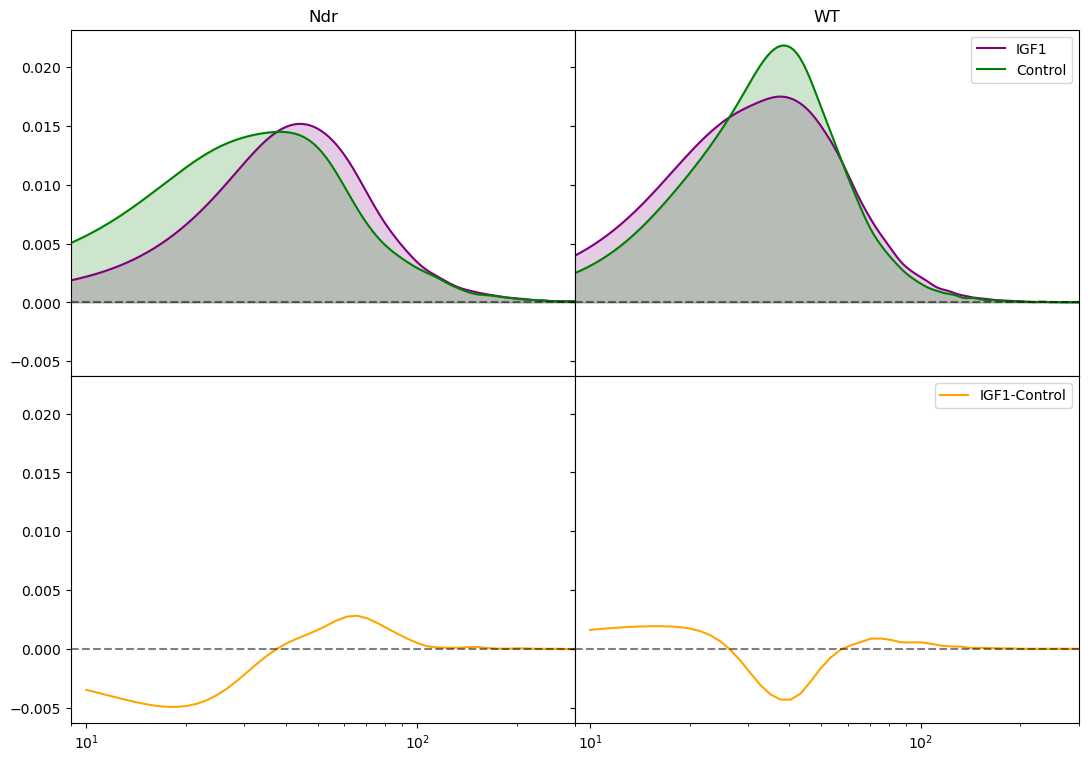

In [19]:
wt_areas = nuclei_size.query('condition == "WT"')
ndr_areas = nuclei_size.query('condition == "Ndr"')

print('How different are Ndr nuclei?')
print(wasserstein_distance(ndr_areas.query('igf1 == "IGF1"').area.values, ndr_areas.query('igf1 == "Control"').area.values))

print('How different are WT nuclei?')
print(wasserstein_distance(wt_areas.query('igf1 == "IGF1"').area.values, wt_areas.query('igf1 == "Control"').area.values))

fig, axs = plt.subplots(2, 2, figsize=(13, 9), sharex=True, sharey=True)

for n, (areas, genotype) in enumerate(zip([ndr_areas, wt_areas], ['Ndr', 'WT'])):
    ctrl_areas = areas.query('igf1 == "Control"').area.values
    igf1_areas = areas.query('igf1 == "IGF1"').area.values
    
    igf1_kde = gaussian_kde(igf1_areas, bw_method='scott')
    ctrl_kde = gaussian_kde(ctrl_areas, bw_method='scott')
    
    x = np.logspace(0, 3, 300)
    
    axs[0, n].plot(x, igf1_kde(x), color=treatment_palette['IGF1'], label='IGF1')
    axs[0, n].fill_between(x, igf1_kde(x), color=treatment_palette['IGF1'], alpha=0.2)
    
    axs[0, n].plot(x, ctrl_kde(x), color=treatment_palette['Control'], label='Control')
    axs[0, n].fill_between(x, ctrl_kde(x), color=treatment_palette['Control'], alpha=0.2)
    
    axs[0, n].axhline(y=0, color='k', alpha=0.5, ls='--')
    axs[0, n].set_title(genotype)
    
    x = np.logspace(1, 4, 100)
    axs[1, n].plot(x, igf1_kde(x)-ctrl_kde(x), color='orange', label='IGF1-Control')
    axs[1, n].semilogx()
    
    axs[1, n].axhline(y=0, color='k', alpha=0.5, ls='--')

plt.subplots_adjust(hspace=0, wspace=0)
plt.xlim((9, 300))
axs[0, 1].legend()
axs[1, 1].legend()
plt.show()

Kolmogorov-Smirnoff show that IGF1 treated and Control distributions are different in Wt and Ndr.

Wasserstein distance is similar to Earth mover distance. It relates to the amount of dirt moved (probability) multiplied by the ground distance over which it is moved (change in size) to get from one distribution to the other. In this particular case, it shows that for Ndr, IGF1 has a "stronger" effect as the distribution is more different.

If we look into differences in the KDE of the distributions, we can see that Ndr IGF1 treated organoids have less of the small nuclei and more of the bigger nuclei. If we consider nuclei bigger than 100 $\mu$m$^2$, there doesn't seem to be differences in treatment. For WT nuclei, IGF1 treated organoids have a bit more variance as the distributions looks wider (and shorter due to normalization).

Let's see what happens if we only analyze the big nuclei (associated to hepatocyte-like cells)

In [20]:
threshold = 201
nuclei_size['big'] = nuclei_size.area.values > threshold

C:\Users\agucor\Anaconda3\envs\organoids\lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  func(*plot_args, **plot_kwargs)
C:\Users\agucor\Anaconda3\envs\organoids\lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  func(*plot_args, **plot_kwargs)


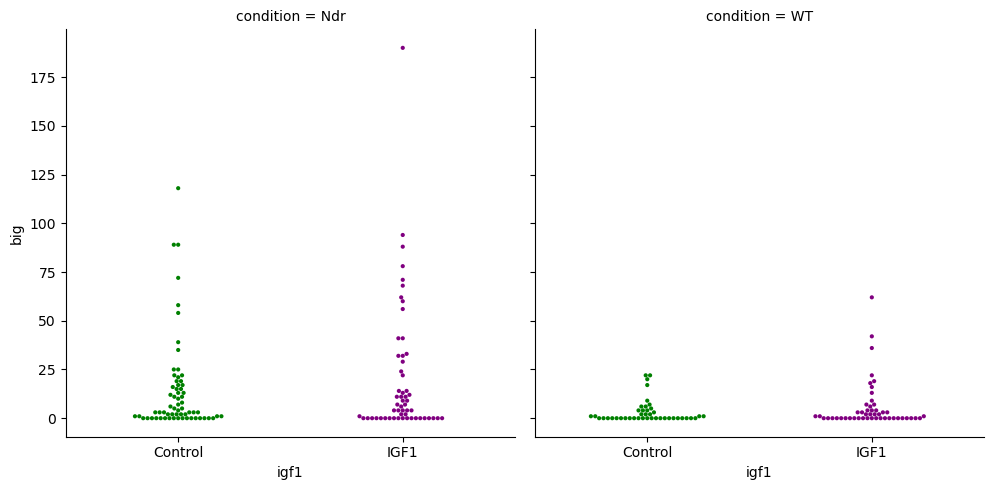

In [21]:
big_count_df = nuclei_size.groupby('sample_name').agg({'condition': 'first', 'region': 'first', 'cell_line': 'first', 'igf1': 'first', 'big': np.sum})

g = sns.FacetGrid(data=big_count_df, col='condition', height=5)
g.map_dataframe(sns.swarmplot, y='big', x='igf1', size=3, palette=treatment_palette)
g.add_legend()
plt.show()

In [22]:
def dunn_test(sample_df):
    return sp.posthoc_dunn(sample_df, val_col='big', group_col='igf1', p_adjust='bonferroni')

In [23]:
for this_genotype, this_df in nuclei_size.groupby('condition'):
    big_count_df = this_df.groupby('sample_name').agg({'condition': 'first', 'region': 'first', 'cell_line': 'first', 'igf1': 'first', 'big': np.sum})
    print(this_genotype)
    print('Dunn\n-------\n')
    print(dunn_test(big_count_df))

Ndr
Dunn
-------

          Control      IGF1
Control  1.000000  0.708835
IGF1     0.708835  1.000000
WT
Dunn
-------

          Control      IGF1
Control  1.000000  0.411938
IGF1     0.411938  1.000000


According to Dunn tests, there is not a statistical difference between applying IGF1 or not in the number of big nuclei found.

## 2. Does IGF1 affect differently peripheral derived organoids from hilar ones?

We can group by condition (WT and Ndr) and region (Periphery and Hilar) and see whether IGF1 treated organoids show a shifted distribution of nuclei sizes towards smaller nuclei.

Are Ndr IGF1 treated nuclei smaller in Hilar-derived organoids?
KstestResult(statistic=0.19943054319980716, pvalue=0.0)
Are Ndr IGF1 treated nuclei smaller in Periphery-derived organoids?
KstestResult(statistic=0.11305184200015153, pvalue=1.2025351680585731e-63)
Are WT IGF1 treated nuclei smaller in Hilar-derived organoids?
KstestResult(statistic=0.12261944223285826, pvalue=1.5947234418446887e-159)
Are WT IGF1 treated nuclei smaller in Periphery-derived organoids?
KstestResult(statistic=0.04908733117372127, pvalue=5.974381320911569e-23)


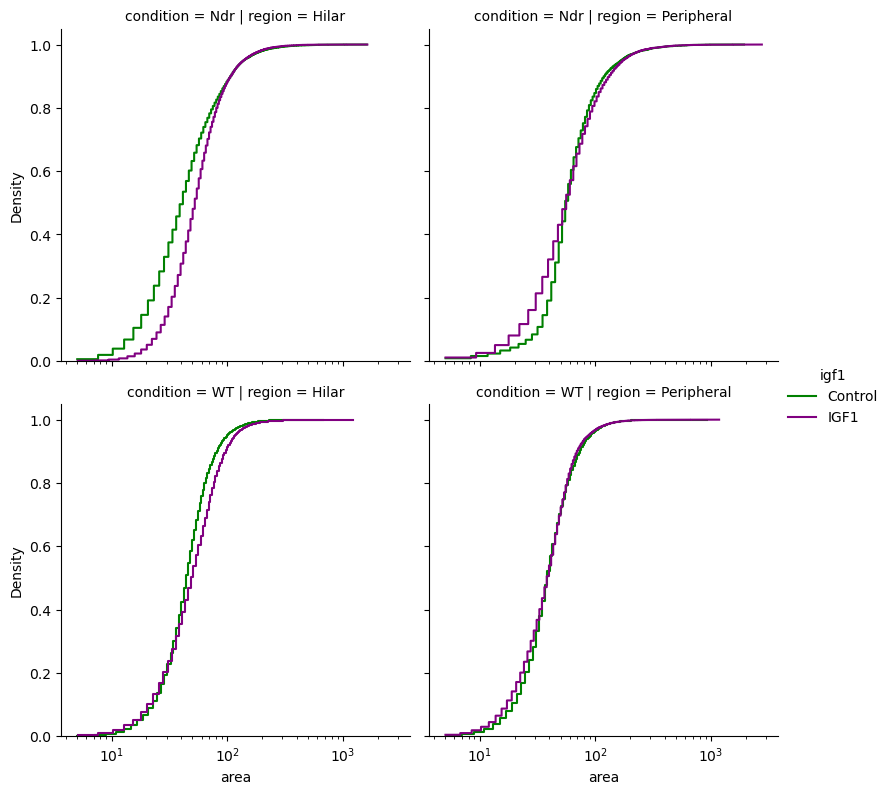

In [24]:
wt_areas = nuclei_size.query('condition == "WT"')
ndr_areas = nuclei_size.query('condition == "Ndr"')

print('Are Ndr IGF1 treated nuclei smaller in Hilar-derived organoids?')
print(kstest(ndr_areas.query('region == "Hilar" and igf1 == "IGF1"').area.values, ndr_areas.query('region == "Hilar" and igf1 == "Control"').area.values, alternative='two-sided'))

print('Are Ndr IGF1 treated nuclei smaller in Periphery-derived organoids?')
print(kstest(ndr_areas.query('region == "Peripheral" and igf1 == "IGF1"').area.values, ndr_areas.query('region == "Peripheral" and igf1 == "Control"').area.values, alternative='two-sided'))

print('Are WT IGF1 treated nuclei smaller in Hilar-derived organoids?')
print(kstest(wt_areas.query('region == "Hilar" and igf1 == "IGF1"').area.values, wt_areas.query('region == "Hilar" and igf1 == "Control"').area.values, alternative='two-sided'))

print('Are WT IGF1 treated nuclei smaller in Periphery-derived organoids?')
print(kstest(wt_areas.query('region == "Peripheral" and igf1 == "IGF1"').area.values, wt_areas.query('region == "Peripheral" and igf1 == "Control"').area.values, alternative='two-sided'))


g = sns.FacetGrid(data=nuclei_size, row='condition', col='region', hue='igf1', height=4, palette=treatment_palette)
g.map_dataframe(sns.histplot, x="area", cumulative=True, fill=False, element='step', stat='density', common_norm=False, )
g.add_legend()
plt.semilogx()
plt.show()

How different are Ndr nuclei in Hilar derived organoids?
9.796347790910628
How different are WT nuclei in Hilar derived organoids?
7.3579442939789645
How different are Ndr nuclei in Peripheral derived organoids?
6.279300394782396
How different are WT nuclei in Peripheral derived organoids?
1.7189924113944266


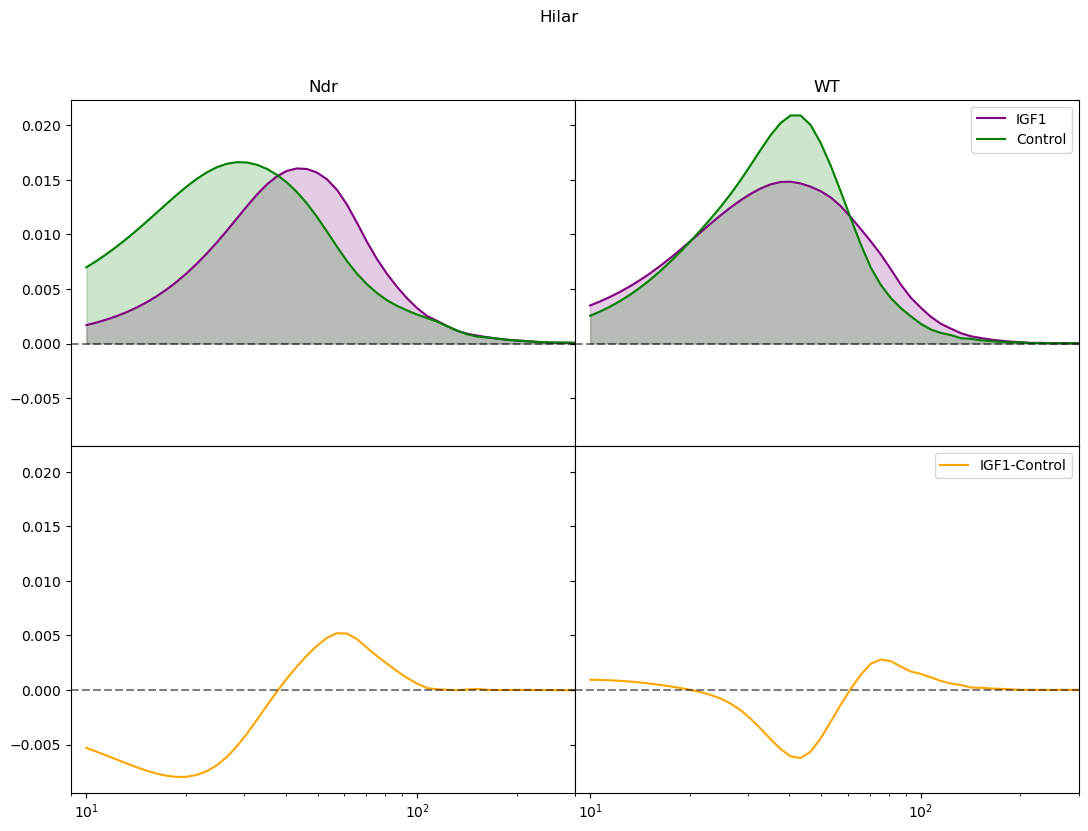

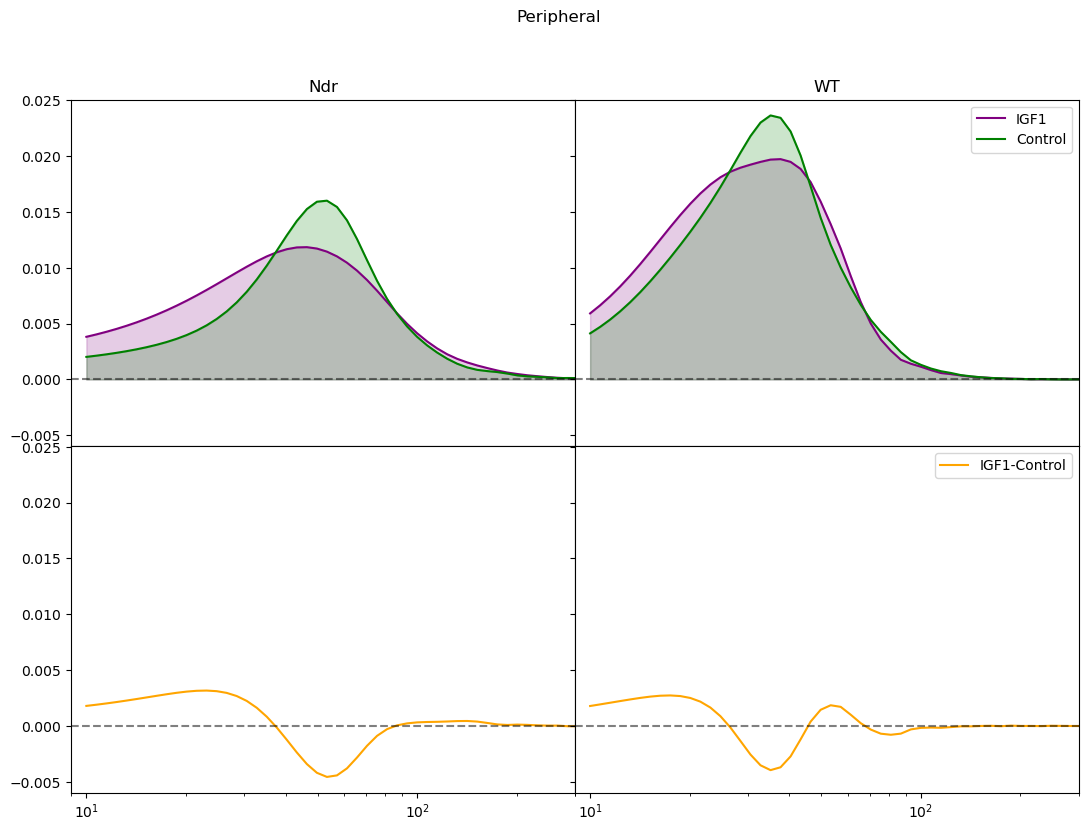

In [25]:
for region in ['Hilar', 'Peripheral']:
    fig, axs = plt.subplots(2, 2, figsize=(13, 9), sharex=True, sharey=True)
    
    for n, genotype in enumerate(['Ndr', 'WT']):
        print(f'How different are {genotype} nuclei in {region} derived organoids?')
        print(wasserstein_distance(nuclei_size.query(f'condition == "{genotype}" and region == "{region}" and igf1 == "IGF1"').area.values, nuclei_size.query(f'condition == "{genotype}" and region == "{region}" and igf1 == "Control"').area.values))

        ctrl_areas = nuclei_size.query(f'condition == "{genotype}" and region == "{region}" and igf1 == "Control"').area.values
        igf1_areas = nuclei_size.query(f'condition == "{genotype}" and region == "{region}" and igf1 == "IGF1"').area.values

        igf1_kde = gaussian_kde(igf1_areas, bw_method='scott')
        ctrl_kde = gaussian_kde(ctrl_areas, bw_method='scott')

        axs[0, n].plot(x, igf1_kde(x), color=treatment_palette['IGF1'], label='IGF1')
        axs[0, n].fill_between(x, igf1_kde(x), color=treatment_palette['IGF1'], alpha=0.2)

        axs[0, n].plot(x, ctrl_kde(x), color=treatment_palette['Control'], label='Control')
        axs[0, n].fill_between(x, ctrl_kde(x), color=treatment_palette['Control'], alpha=0.2)

        axs[0, n].axhline(y=0, color='k', alpha=0.5, ls='--')
        axs[0, n].set_title(genotype)

        x = np.logspace(1, 4, 100)
        axs[1, n].plot(x, igf1_kde(x)-ctrl_kde(x), color='orange', label='IGF1-Control')
        axs[1, n].semilogx()

        axs[1, n].axhline(y=0, color='k', alpha=0.5, ls='--')

    plt.subplots_adjust(hspace=0, wspace=0)
    plt.xlim((9, 300))
    axs[0, 1].legend()
    axs[1, 1].legend()
    plt.suptitle(region)

Kolmogorov-Smirnoff show that IGF1 treated and Control distributions are different in Wt and Ndr.

Wasserstein distance is similar to Earth mover distance. It relates to the amount of dirt moved (probability) multiplied by the ground distance over which it is moved (change in size) to get from one distribution to the other. In this particular case, it shows that for Ndr, IGF1 has a "stronger" effect as the distribution is more different. Differences are smaller in Peripheral-derived organoids.

If we look into differences in the KDE of the distributions, we can see that Ndr IGF1 treated organoids have less of the small nuclei and more of the bigger nuclei. If we consider nuclei bigger than 100 $\mu$m$^2$, there doesn't seem to be differences in treatment. For WT nuclei, IGF1 treated organoids have a bit more variance as the distributions looks wider (and shorter due to normalization).

Let's see what happens if we only analyze the big nuclei (associated to hepatocyte-like cells)

In [26]:
threshold = 201
nuclei_size['big'] = nuclei_size.area.values > threshold

C:\Users\agucor\Anaconda3\envs\organoids\lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  func(*plot_args, **plot_kwargs)
C:\Users\agucor\Anaconda3\envs\organoids\lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  func(*plot_args, **plot_kwargs)
C:\Users\agucor\Anaconda3\envs\organoids\lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  func(*plot_args, **plot_kwargs)
C:\Users\agucor\Anaconda3\envs\organoids\lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  func(*plot_args, **plot_kwargs)


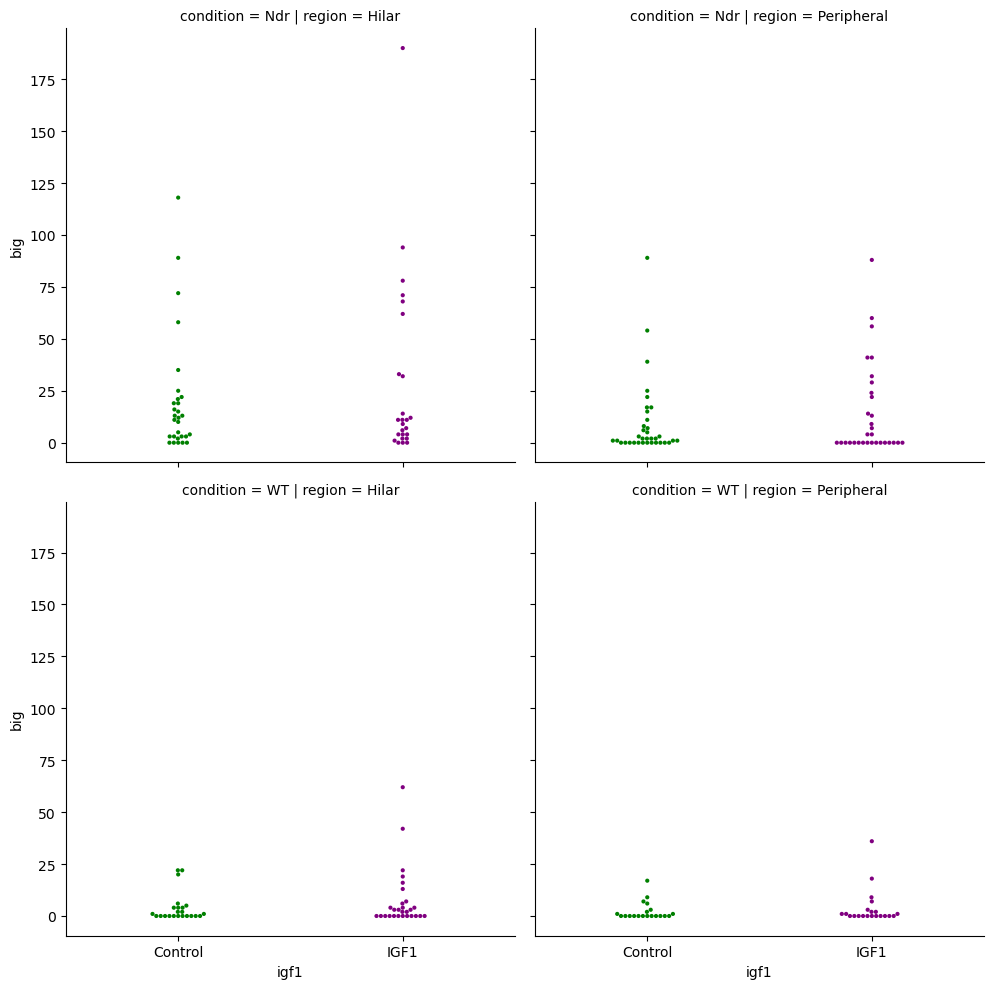

In [27]:
big_count_df = nuclei_size.groupby('sample_name').agg({'condition': 'first', 'region': 'first', 'cell_line': 'first', 'igf1': 'first', 'big': np.sum})

g = sns.FacetGrid(data=big_count_df, row='condition', col='region', height=5)
g.map_dataframe(sns.swarmplot, y='big', x='igf1', size=3, palette=treatment_palette)
g.add_legend()
plt.show()

In [28]:
def dunn_test(sample_df):
    return sp.posthoc_dunn(sample_df, val_col='big', group_col='igf1', p_adjust='bonferroni')

In [29]:
for (this_genotype, this_region), this_df in nuclei_size.groupby(['condition', 'region']):
    big_count_df = this_df.groupby('sample_name').agg({'condition': 'first', 'region': 'first', 'cell_line': 'first', 'igf1': 'first', 'big': np.sum})
    print(f'{this_genotype} from {this_region}')
    print('Dunn\n-------\n')
    print(dunn_test(big_count_df))

Ndr from Hilar
Dunn
-------

          Control      IGF1
Control  1.000000  0.855134
IGF1     0.855134  1.000000
Ndr from Peripheral
Dunn
-------

          Control      IGF1
Control  1.000000  0.952017
IGF1     0.952017  1.000000
WT from Hilar
Dunn
-------

          Control      IGF1
Control  1.000000  0.498911
IGF1     0.498911  1.000000
WT from Peripheral
Dunn
-------

          Control      IGF1
Control  1.000000  0.655541
IGF1     0.655541  1.000000


According to Dunn tests, there is not a statistical difference between applying IGF1 or not in the number of big nuclei found.

## 3. Does IGF1 treatment make nuclei distributions more similar to WT?

For this we should compare Ndr treated conditions against their WT untreated condition.

Are Ndr IGF1 treated nuclei similar to WT untreated in Hilar-derived organoids?
KstestResult(statistic=0.15288804896675579, pvalue=3.8367312905703864e-290)
Are Ndr IGF1 treated nuclei similar to WT untreated in Peripheral-derived organoids?
KstestResult(statistic=0.29387370015259634, pvalue=0.0)


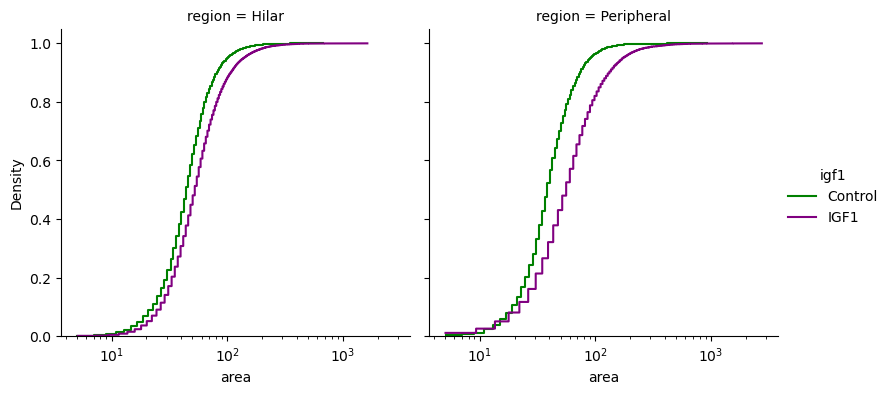

In [30]:
wt_areas = nuclei_size.query('condition == "WT"')
ndr_areas = nuclei_size.query('condition == "Ndr"')

print('Are Ndr IGF1 treated nuclei similar to WT untreated in Hilar-derived organoids?')
print(kstest(ndr_areas.query('region == "Hilar" and igf1 == "IGF1"').area.values, wt_areas.query('region == "Hilar" and igf1 == "Control"').area.values, alternative='two-sided'))

print('Are Ndr IGF1 treated nuclei similar to WT untreated in Peripheral-derived organoids?')
print(kstest(ndr_areas.query('region == "Peripheral" and igf1 == "IGF1"').area.values, wt_areas.query('region == "Peripheral" and igf1 == "Control"').area.values, alternative='two-sided'))

g = sns.FacetGrid(data=nuclei_size.drop(
    nuclei_size.query('condition == "WT" and igf1 == "IGF1"').index).drop(
    nuclei_size.query('condition == "Ndr" and igf1 == "Control"').index), col='region', hue='igf1', height=4, palette=treatment_palette)
g.map_dataframe(sns.histplot, x="area", cumulative=True, fill=False, element='step', stat='density', common_norm=False, )
g.add_legend()
plt.semilogx()
plt.show()

How different are Ndr Control nuclei from WT untreated nuclei in Hilar derived organoids?
11.604075996871112
How different are Ndr IGF1 nuclei from WT untreated nuclei in Hilar derived organoids?
12.901790408415813
How different are Ndr Control nuclei from WT untreated nuclei in Peripheral derived organoids?
28.578242000472855
How different are Ndr IGF1 nuclei from WT untreated nuclei in Peripheral derived organoids?
28.61267108904893


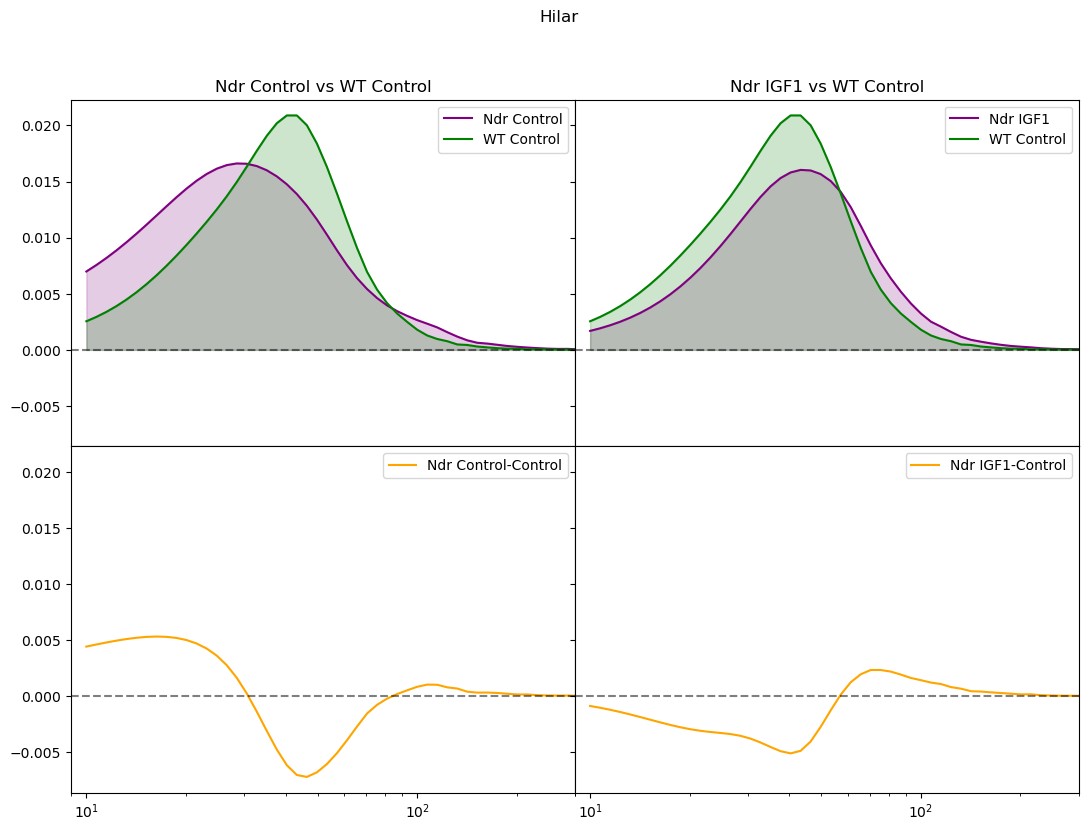

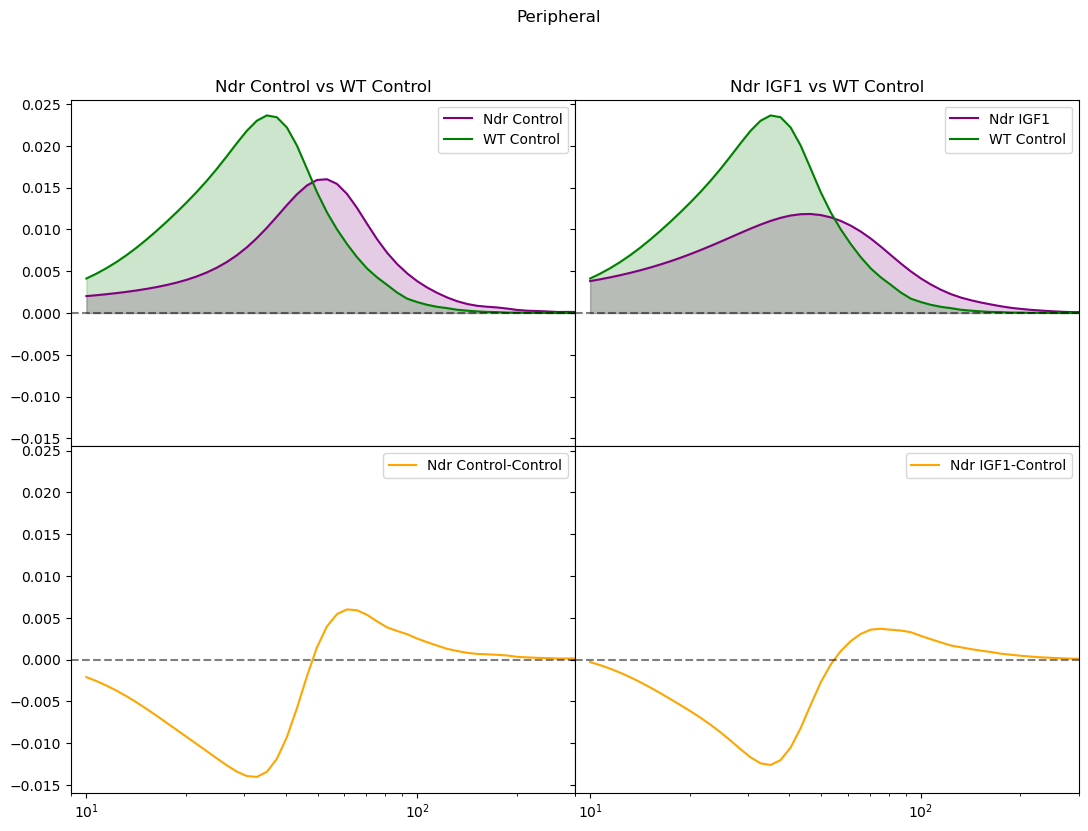

In [31]:
for region in ['Hilar', 'Peripheral']:
    fig, axs = plt.subplots(2, 2, figsize=(13, 9), sharex=True, sharey=True)
    for n, treatment in enumerate(['Control', 'IGF1']):
        print(f'How different are Ndr {treatment} nuclei from WT untreated nuclei in {region} derived organoids?')
        print(wasserstein_distance(nuclei_size.query(f'condition == "Ndr" and region == "{region}" and igf1 == "{treatment}"').area.values, nuclei_size.query(f'condition == "WT" and region == "{region}" and igf1 == "Control"').area.values))

        ctrl_areas = nuclei_size.query(f'condition == "WT" and region == "{region}" and igf1 == "Control"').area.values
        igf1_areas = nuclei_size.query(f'condition == "Ndr" and region == "{region}" and igf1 == "{treatment}"').area.values

        igf1_kde = gaussian_kde(igf1_areas, bw_method='scott')
        ctrl_kde = gaussian_kde(ctrl_areas, bw_method='scott')

        axs[0, n].plot(x, igf1_kde(x), color=treatment_palette['IGF1'], label=f'Ndr {treatment}')
        axs[0, n].fill_between(x, igf1_kde(x), color=treatment_palette['IGF1'], alpha=0.2)

        axs[0, n].plot(x, ctrl_kde(x), color=treatment_palette['Control'], label='WT Control')
        axs[0, n].fill_between(x, ctrl_kde(x), color=treatment_palette['Control'], alpha=0.2)

        axs[0, n].axhline(y=0, color='k', alpha=0.5, ls='--')
        axs[0, n].set_title(f'Ndr {treatment} vs WT Control')

        x = np.logspace(1, 4, 100)
        axs[1, n].plot(x, igf1_kde(x)-ctrl_kde(x), color='orange', label=f'Ndr {treatment}-Control')
        axs[1, n].semilogx()

        axs[1, n].axhline(y=0, color='k', alpha=0.5, ls='--')
        axs[0, n].legend()
        axs[1, n].legend()

    plt.subplots_adjust(hspace=0, wspace=0)
    plt.xlim((9, 300))
    plt.suptitle(region)

Kolmogorov-Smirnoff show that Ndr IGF1 treated and WT Control distributions are still different.

Wasserstein distance is similar to Earth mover distance. It relates to the amount of dirt moved (probability) multiplied by the ground distance over which it is moved (change in size) to get from one distribution to the other. In this particular case, it shows that differences are still higher in Peripheral-derived organoids. We could see how different Ndr untreated is from WT to see if there is an improvement.

Let's see what happens if we only analyze the big nuclei (associated to hepatocyte-like cells)

In [32]:
threshold = 201
nuclei_size['big'] = nuclei_size.area.values > threshold

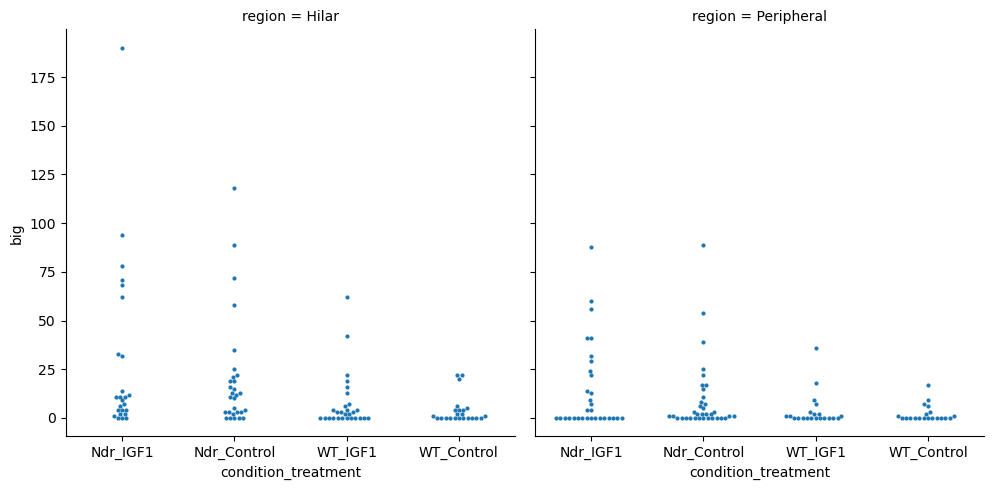

In [33]:
big_count_df = nuclei_size.groupby('sample_name').agg({'condition': 'first', 'region': 'first', 'cell_line': 'first', 'igf1': 'first', 'big': np.sum})
big_count_df['condition_treatment'] = big_count_df.apply(lambda x: '_'.join([x.condition, x.igf1]), axis=1)

g = sns.FacetGrid(data=big_count_df, col='region', height=5)
g.map_dataframe(sns.swarmplot, y='big', x='condition_treatment', size=3)
g.add_legend()
plt.show()

In [34]:
def dunn_test(sample_df):
    return sp.posthoc_dunn(sample_df, val_col='big', group_col='condition_treatment', p_adjust='bonferroni')

In [35]:
for this_region, this_df in nuclei_size.groupby('region'):
    big_count_df = this_df.groupby('sample_name').agg({'condition': 'first', 'region': 'first', 'cell_line': 'first', 'igf1': 'first', 'big': np.sum})
    big_count_df['condition_treatment'] = big_count_df.apply(lambda x: '_'.join([x.condition, x.igf1]), axis=1)
    print(f'{this_genotype} from {this_region}')
    print('Dunn\n-------\n')
    print(dunn_test(big_count_df))

WT from Hilar
Dunn
-------

             Ndr_Control  Ndr_IGF1  WT_Control   WT_IGF1
Ndr_Control     1.000000  1.000000    0.009960  0.055607
Ndr_IGF1        1.000000  1.000000    0.005443  0.030878
WT_Control      0.009960  0.005443    1.000000  1.000000
WT_IGF1         0.055607  0.030878    1.000000  1.000000
WT from Peripheral
Dunn
-------

             Ndr_Control  Ndr_IGF1  WT_Control   WT_IGF1
Ndr_Control     1.000000  1.000000    0.348202  0.830947
Ndr_IGF1        1.000000  1.000000    0.610969  1.000000
WT_Control      0.348202  0.610969    1.000000  1.000000
WT_IGF1         0.830947  1.000000    1.000000  1.000000


According to Dunn tests, there are statistical differences in Hilar region derived organoids from WT Control and Ndr Control, WT Control and Ndr IGF1 treated and WT IGF1 treated and Ndr IGF1 treated. There is not a statistical difference between Ndr applying IGF1 or not in the number of big nuclei found.

With regards to Peripheral derived organoids, there is no statistical difference between applying IGF1 or not in the number of big nuclei found.

# Comparison with previous dataset

We should corroborate that results from this dataset follow previosuly presented results in the previous dataset.

In [36]:
OLD_DATA_DIR = pathlib.Path(r'C:\Users\agucor\Karolinska Institutet\Afshan Iqbal - EdU staining Non-IGF1 exp')

In [37]:
nuclei_size_old = pd.read_excel(OLD_DATA_DIR / 'nuclei_size.xlsx', sheet_name=None)
dfs = []
for sample_name, sample_df in nuclei_size_old.items():
    sample_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
    sample_df['sample_name'] = sample_name
    dfs.append(sample_df)

nuclei_size_old = pd.concat(dfs, ignore_index=True)

In [38]:
nuclei_size_old['condition'] = nuclei_size_old.sample_name.apply(parse_condition)
nuclei_size_old['cell_line'] = nuclei_size_old.sample_name.apply(parse_cell_line)
nuclei_size_old['region'] = nuclei_size_old.sample_name.apply(parse_region)
nuclei_size_old['sample_number'] = nuclei_size_old.sample_name.apply(parse_sample_number)

nuclei_size_old = nuclei_size_old.astype({'label': int, 'condition': 'category', 'cell_line': 'category', 'region': 'category', 'sample_number': 'category'})

In [39]:
nuclei_size_old

,area_2D,eccentricity,equivalent_diameter_area,intensity_mean_2D,label,z,area_3D,intensity_mean_3D,area,volume,sample_name,condition,cell_line,region,sample_number
0,1036,0.572159,36.319088,17185.166988,2,3,7322,10333.292133,79.040874,2234.506880,Ndr1219 p8 Hilar-1,Ndr,1219,Hilar,1
1,765,0.443916,31.209426,14916.526797,4,5,3966,10774.640696,58.365124,1210.332462,Ndr1219 p8 Hilar-1,Ndr,1219,Hilar,1
2,638,0.778079,28.501348,12053.150470,9,3,3742,7978.092197,48.675751,1141.972787,Ndr1219 p8 Hilar-1,Ndr,1219,Hilar,1
3,711,0.623056,30.087760,17123.690577,10,3,5060,10684.135968,54.245233,1544.196232,Ndr1219 p8 Hilar-1,Ndr,1219,Hilar,1
4,528,0.805742,25.928179,12609.446970,11,5,2418,9111.187758,40.283380,737.918279,Ndr1219 p8 Hilar-1,Ndr,1219,Hilar,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92810,121,0.916938,12.412171,26513.140496,3511,5,121,26513.140496,18.840016,113.040097,WT1225 Periph-9,WT,1225,Peripheral,9
92811,142,0.848895,13.446190,10091.507042,3512,5,142,10091.507042,22.109771,132.658626,WT1225 Periph-9,WT,1225,Peripheral,9
92812,268,0.844165,18.472363,10178.410448,3517,5,268,10178.410448,41.728300,250.369801,WT1225 Periph-9,WT,1225,Peripheral,9
92813,83,0.653466,10.280023,10708.361446,3520,5,83,10708.361446,12.923317,77.539901,WT1225 Periph-9,WT,1225,Peripheral,9


## Compare datasets

Let's merge both datasets and ignore IGF1 treated organoids from the new dataset.

In [40]:
nuclei_size_all = []

this_df = nuclei_size.query('igf1 != "IGF1"')
this_df['dataset'] = 'new'
nuclei_size_all.append(this_df)

nuclei_size_old['dataset'] = 'old'
nuclei_size_all.append(nuclei_size_old)

nuclei_size_all = pd.concat(nuclei_size_all, ignore_index=True)

C:\Users\agucor\AppData\Local\Temp\ipykernel_22188\3263440099.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_df['dataset'] = 'new'


Are Ndr from Hilar nuclei different between new and old datsets?
KstestResult(statistic=0.17879628178717633, pvalue=6.431886475936829e-287)
Are Ndr from Peripheral nuclei different between new and old datsets?
KstestResult(statistic=0.26237326058259264, pvalue=0.0)
Are WT from Hilar nuclei different between new and old datsets?
KstestResult(statistic=0.07103488680018055, pvalue=1.3322722418412607e-50)
Are WT from Peripheral nuclei different between new and old datsets?
KstestResult(statistic=0.04190054007332766, pvalue=9.037044615752744e-14)


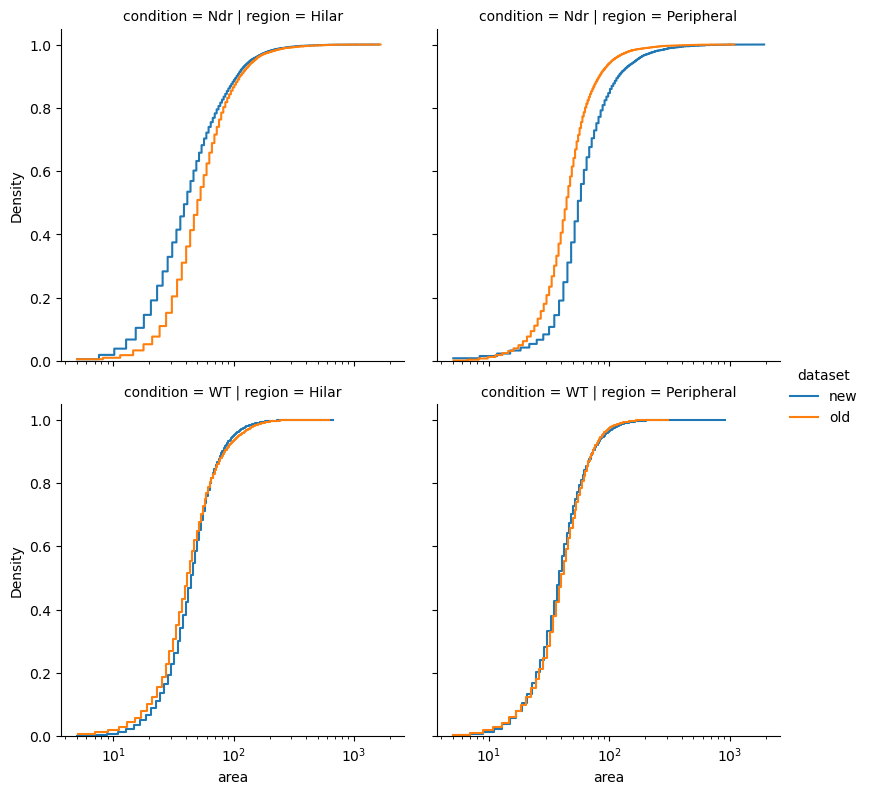

In [41]:
for (this_genotype, this_region), this_df in nuclei_size_all.groupby(['condition', 'region']):
    print(f'Are {this_genotype} from {this_region} nuclei different between new and old datsets?')
    print(kstest(this_df.query('dataset == "new"').area.values, this_df.query('dataset == "old"').area.values, alternative='two-sided'))

g = sns.FacetGrid(data=nuclei_size_all, col='region', row='condition', hue='dataset', height=4)
g.map_dataframe(sns.histplot, x="area", cumulative=True, fill=False, element='step', stat='density', common_norm=False, )
g.add_legend()
plt.semilogx()
plt.show()

How different are WT nuclei between datasets in Hilar derived organoids?
3.388273826782779
How different are Ndr nuclei between datasets in Hilar derived organoids?
10.26267965015139
How different are WT nuclei between datasets in Peripheral derived organoids?
2.0369903512291447
How different are Ndr nuclei between datasets in Peripheral derived organoids?
20.994776995388456


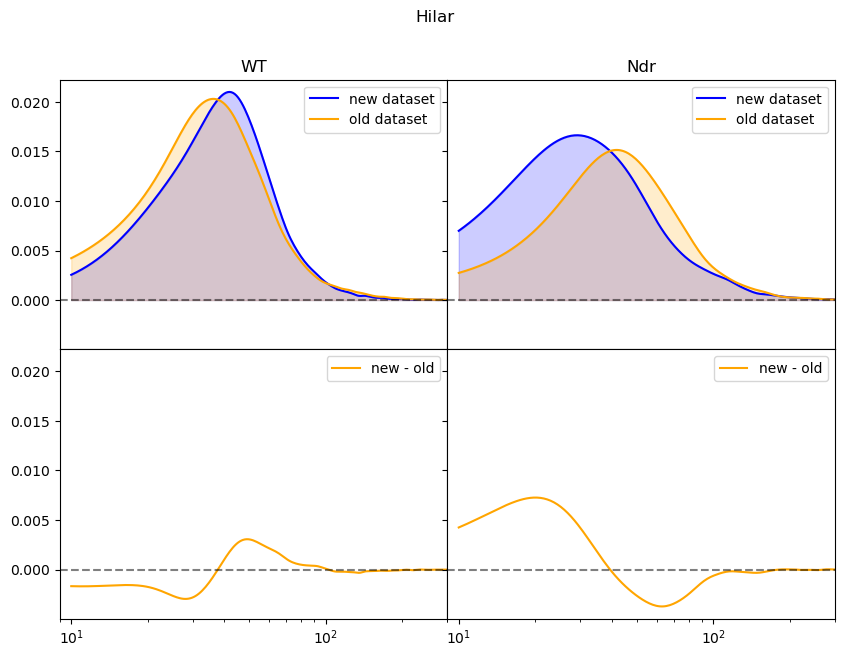

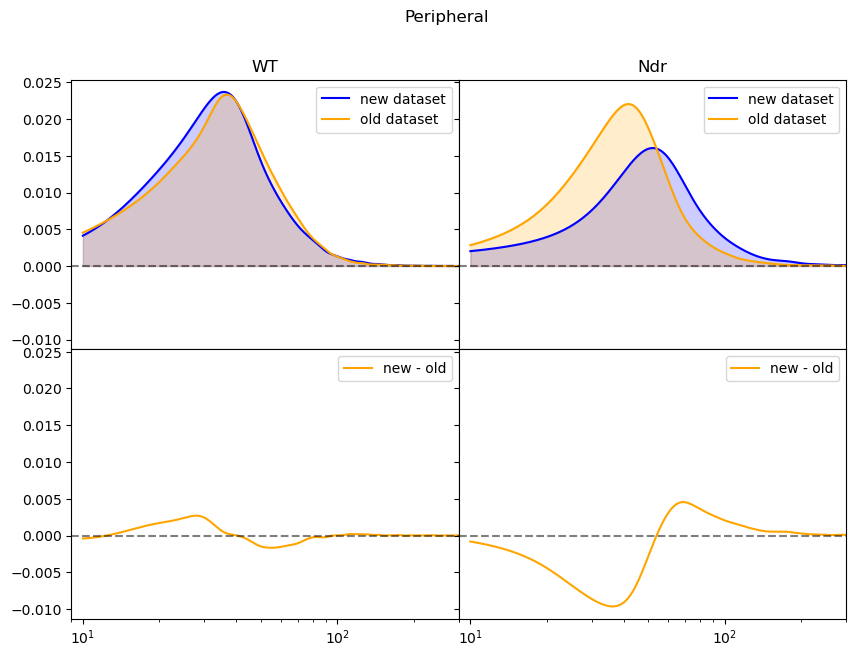

In [42]:
for region in ['Hilar', 'Peripheral']:
    fig, axs = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)
    for n, this_genotype in enumerate(['WT', 'Ndr']):
        print(f'How different are {this_genotype} nuclei between datasets in {region} derived organoids?')
        print(wasserstein_distance(nuclei_size_all.query(f'condition == "{this_genotype}" and region == "{region}" and dataset == "new"').area.values, 
                                   nuclei_size_all.query(f'condition == "{this_genotype}" and region == "{region}" and dataset == "old"').area.values))

        ctrl_areas = nuclei_size_all.query(f'condition == "{this_genotype}" and region == "{region}" and dataset == "old"').area.values
        igf1_areas = nuclei_size_all.query(f'condition == "{this_genotype}" and region == "{region}" and dataset == "new"').area.values

        igf1_kde = gaussian_kde(igf1_areas, bw_method='scott')
        ctrl_kde = gaussian_kde(ctrl_areas, bw_method='scott')

        x = np.logspace(1, 3, 300)
        
        axs[0, n].plot(x, igf1_kde(x), color='blue', label=f'new dataset')
        axs[0, n].fill_between(x, igf1_kde(x), color='blue', alpha=0.2)

        axs[0, n].plot(x, ctrl_kde(x), color='orange', label='old dataset')
        axs[0, n].fill_between(x, ctrl_kde(x), color='orange', alpha=0.2)

        axs[0, n].axhline(y=0, color='k', alpha=0.5, ls='--')
        axs[0, n].set_title(this_genotype)

        axs[1, n].plot(x, igf1_kde(x)-ctrl_kde(x), color='orange', label=f'new - old')
        axs[1, n].semilogx()

        axs[1, n].axhline(y=0, color='k', alpha=0.5, ls='--')
        axs[0, n].legend()
        axs[1, n].legend()

    plt.subplots_adjust(hspace=0, wspace=0)
    plt.xlim((9, 300))
    plt.suptitle(region)

Kolmogorov-Smirnof test shows that there are diferences between the datasets. This is expected as comparing such huge samples will detect even smallest batch effects. Following, we measured Earth Mover's Distance to assess how different are the datasets. WT datasets are not very different from one another, yet differences seem to be more profound when comparing Ndr derived datasets.

In [43]:
threshold = 201
nuclei_size_all['big'] = nuclei_size_all.area.values > threshold

In [44]:
# Check that names across datasets are not repeated
any([name in nuclei_size_all.query('dataset == "old"').sample_name.unique() for name in nuclei_size_all.query('dataset == "new"').sample_name.unique()])

False

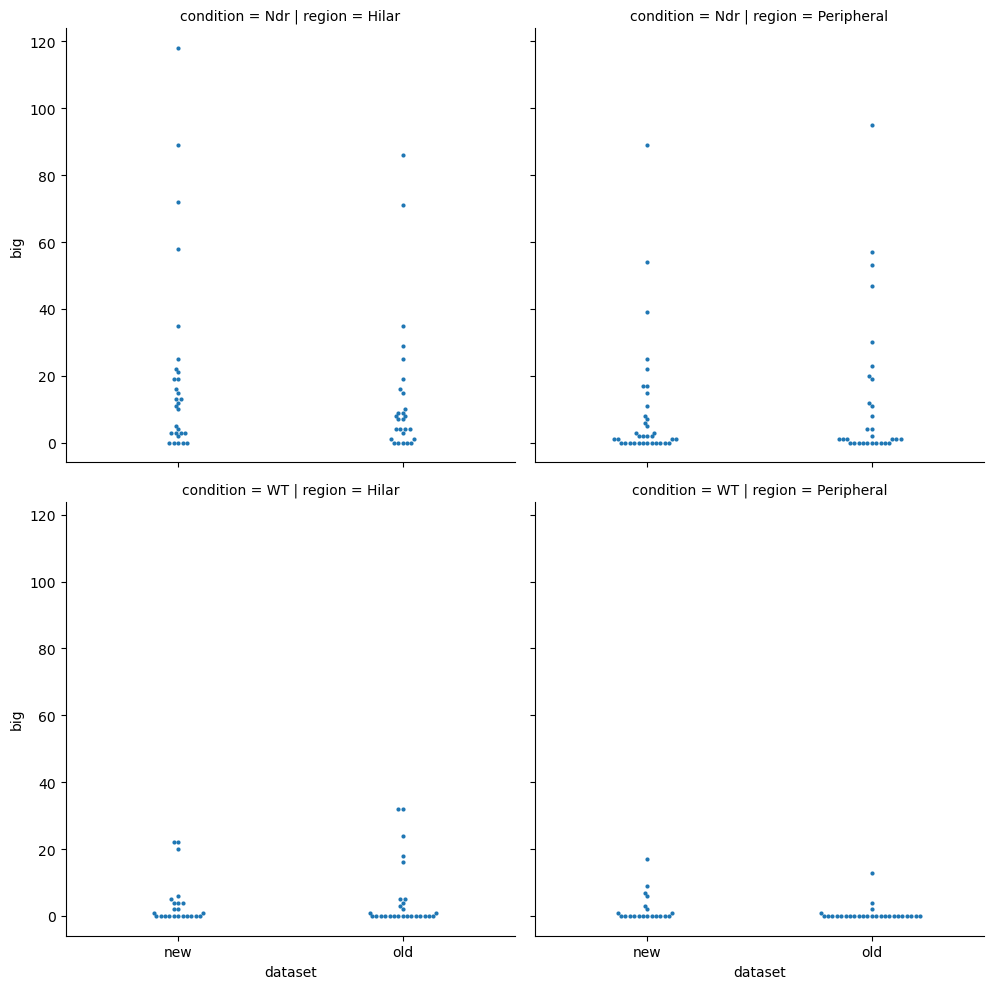

In [45]:
big_count_df = nuclei_size_all.groupby('sample_name').agg({'condition': 'first', 'region': 'first', 'cell_line': 'first', 'dataset': 'first', 'big': np.sum})

g = sns.FacetGrid(data=big_count_df, row='condition', col='region', height=5)
g.map_dataframe(sns.swarmplot, y='big', x='dataset', size=3)
g.add_legend()
plt.show()

In [46]:
def dunn_test(sample_df):
    return sp.posthoc_dunn(sample_df, val_col='big', group_col='dataset', p_adjust='bonferroni')

In [47]:
for (this_genotype, this_region), this_df in nuclei_size_all.groupby(['condition', 'region']):
    big_count_df = this_df.groupby('sample_name').agg({'condition': 'first', 'region': 'first', 'cell_line': 'first', 'dataset': 'first', 'big': np.sum})
    
    print(f'\n{this_genotype} from {this_region}\n')
    print('Number of big nuclei (sum) in number of organoids (len)\n-------\n')
    print(big_count_df.groupby('dataset').big.agg([sum, len]))
    print('\nDunn\n-------\n')
    print(dunn_test(big_count_df))


Ndr from Hilar

Number of big nuclei (sum) in number of organoids (len)
-------

         sum  len
dataset          
new      591   29
old      375   27

Dunn
-------

          new       old
new  1.000000  0.378558
old  0.378558  1.000000

Ndr from Peripheral

Number of big nuclei (sum) in number of organoids (len)
-------

         sum  len
dataset          
new      333   35
old      391   30

Dunn
-------

          new       old
new  1.000000  0.808697
old  0.808697  1.000000

WT from Hilar

Number of big nuclei (sum) in number of organoids (len)
-------

         sum  len
dataset          
new       93   23
old      143   27

Dunn
-------

         new      old
new  1.00000  0.79281
old  0.79281  1.00000

WT from Peripheral

Number of big nuclei (sum) in number of organoids (len)
-------

         sum  len
dataset          
new       46   20
old       20   27

Dunn
-------

         new      old
new  1.00000  0.05094
old  0.05094  1.00000


According to Dunn tests, There are no statistical differences in the number of big organoids in each condition between the old and new datasets, except for WT Peripheral.